In [26]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score 
from dataFrameCovid import DataFrameCovid as dfc
from sklearn.metrics import classification_report
from geraArquivo1 import GeraArquivo as ga

In [27]:
# Monta dataframe com nome dos arquivos
df = dfc.getDf()

d:\DropB\Faculeste\TCC\codigos\dataFrameCovid.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [28]:
# Variáveis de controle
nImagens = len(df)
percentual = 0.8
tamanhoDoLote = 200
epocas = 50
passosPorEpoca = int(nImagens*percentual // tamanhoDoLote)
passosPorValidacao = int(nImagens*(1.0 - percentual) // tamanhoDoLote)
width = 64
height = 64
depth = 3
classes = 2
inputShape = (height, width, depth)
passosPorEpoca, passosPorValidacao

(27, 6)

In [29]:
# gerando dataframes de treinamento e de teste
dfTreinamento = df.sample(frac=0.8, random_state=100) # 70% de treinamento
dfTeste = df[~df['arquivo'].isin(dfTreinamento['arquivo'])]     # 30% de teste

In [30]:
imgGen = ImageDataGenerator(rescale = 1./255, 
                            shear_range=0.25, 
                            zoom_range = 0.25, 
                            horizontal_flip = True)

conjTreinamento = imgGen.flow_from_dataframe(dfTreinamento, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

conjTeste = imgGen.flow_from_dataframe(dfTeste, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

Found 5440 validated image filenames belonging to 2 classes.
Found 1360 validated image filenames belonging to 2 classes.


In [31]:
# CheXNet - Ajustar imagens para 32 x 32
from modCxNet import CXNet
cxClf = CXNet()
cxClf = cxClf.build(width=width, height=height, depth=3, classes=2)
cxClf.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d_6[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']       

c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 on)                                                                                              
                                                                                                  
 conv3_block10_1_conv (Conv2D)  (None, 8, 8, 128)    53248       ['conv3_block10_0_relu[0][0]']   
                                                                                                  
 conv3_block10_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv3_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block10_1_relu (Activati  (None, 8, 8, 128)   0           ['conv3_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_blo

In [32]:
print("CxNet ***************************************************")
h1 = cxClf.fit(x=conjTreinamento, steps_per_epoch=passosPorEpoca, epochs=epocas, validation_data=conjTeste, validation_steps=passosPorValidacao, verbose=1).history

CxNet ***************************************************


Epoch 1/50
27/27 [==============================] - 225s 8s/step - loss: 0.4282 - accuracy: 0.7920 - val_loss: 0.6748 - val_accuracy: 0.5808
Epoch 2/50
27/27 [==============================] - 197s 7s/step - loss: 0.3080 - accuracy: 0.8679 - val_loss: 0.7824 - val_accuracy: 0.4400
Epoch 3/50
27/27 [==============================] - 192s 7s/step - loss: 0.2661 - accuracy: 0.8895 - val_loss: 0.9204 - val_accuracy: 0.4333
Epoch 4/50
27/27 [==============================] - 193s 7s/step - loss: 0.2476 - accuracy: 0.8969 - val_loss: 1.0820 - val_accuracy: 0.4633
Epoch 5/50
27/27 [==============================] - 193s 7s/step - loss: 0.2271 - accuracy: 0.9053 - val_loss: 2.3469 - val_accuracy: 0.4583
Epoch 6/50
27/27 [==============================] - 193s 7s/step - loss: 0.2403 - accuracy: 0.9015 - val_loss: 1.6550 - val_accuracy: 0.4592
Epoch 7/50
27/27 [==============================] - 193s 7s/step - loss: 0.2213 - accuracy: 0.9076 - val_loss: 1.8890 - val_accuracy: 0.4625
Epoch 8/50
27

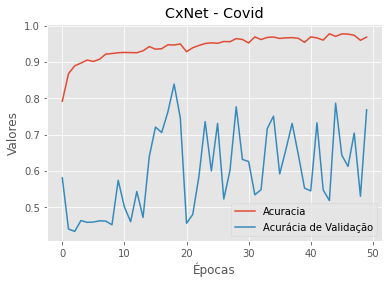

In [33]:
# Gráfico de Acurácia
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epocas), h1["accuracy"], label="Acuracia")
#plt.plot(np.arange(0, epc), h1["loss"], label="Perda")
plt.plot(np.arange(0, epocas), h1["val_accuracy"], label="Acurácia de Validação")
#plt.plot(np.arange(0, epc), h1["val_loss"], label="Perda na Validação")
plt.title("CxNet - Covid")
plt.xlabel("Épocas")
plt.ylabel("Valores")
plt.legend()
plt.show()

In [34]:
prdCxN = cxClf.predict(conjTeste[0][0])
categorias = []
for i in conjTeste[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
predCxNet = []
for i in prdCxN:
    predCxNet.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, predCxNet, target_names=["Não Covid", "Covid"]))

7/7 [==============================] - 3s 218ms/step
              precision    recall  f1-score   support

   Não Covid       0.89      0.66      0.76       116
       Covid       0.65      0.88      0.75        84

    accuracy                           0.76       200
   macro avg       0.77      0.77      0.75       200
weighted avg       0.79      0.76      0.76       200



In [35]:
ga.geraHistorico("arquivos/arqCxNet"+str(epocas)+".csv", h1)
ga.geraPredicao("arquivos/arqPredCxNet"+str(tamanhoDoLote)+".csv", categorias, predCxNet)

In [36]:
'''
df1 = dfc.getDfPredicao()
prdTmnh = len(df1)
conjPred = imgGen.flow_from_dataframe(df1, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                x_col = 'arquivo',
                                y_col = 'categoria',
                                target_size=(width, height), 
                                batch_size=prdTmnh, 
                                class_mode='categorical')
prdLNt = lntClf.predict(conjPred[0][0])
categorias = []
for i in conjPred[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
prdLNet = []
for i in prdLNt:
    prdLNet.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, prdLNet, target_names=["Não Covid", "Covid"]))
'''


'\ndf1 = dfc.getDfPredicao()\nprdTmnh = len(df1)\nconjPred = imgGen.flow_from_dataframe(df1, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", \n                                x_col = \'arquivo\',\n                                y_col = \'categoria\',\n                                target_size=(width, height), \n                                batch_size=prdTmnh, \n                                class_mode=\'categorical\')\nprdLNt = lntClf.predict(conjPred[0][0])\ncategorias = []\nfor i in conjPred[0][1]:\n    categorias.append(0 if i[0] > 0.0 else 1)\nprdLNet = []\nfor i in prdLNt:\n    prdLNet.append(0 if i[0] >= 0.5 else 1)\nprint(classification_report(categorias, prdLNet, target_names=["Não Covid", "Covid"]))\n'